# Visualising The News

## Imports

In [ ]:
!pip install allennlp allennlp-models
!pip install --upgrade google-cloud-storage
!pip install pyLDAvis

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pprint import pprint
import itertools
import scipy.stats
import networkx as nx

from allennlp.predictors.predictor import Predictor
from allennlp.data.tokenizers.sentence_splitter import SpacySentenceSplitter
from allennlp.data.tokenizers.spacy_tokenizer import SpacyTokenizer
import spacy
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, Phrases, phrases, ldamodel, TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

import pyLDAvis
import pyLDAvis.gensim_models

from sklearn.cluster import k_means, KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

## Load Data

In [ ]:
uploaded = files.upload()

Saving airline.csv to airline.csv


In [ ]:
data = pd.read_csv('airline.csv', parse_dates=[1])
data.columns = ['url', 'date', 'title', 'author', 'topic', 'article']
grouped_df = data.groupby(pd.Grouper(key='date', freq='1M'))

""" For now just use one group"""

key = '2021-04-30 00:00:00+0000'
group = grouped_df.get_group(key)
group.reset_index(drop=True, inplace=True)
titles = group['title']
articles = group['article']

In [ ]:
"""Get first 5 sentences from each article """
sentsplitter = SpacySentenceSplitter() 
all_sents = sentsplitter.batch_split_sentences(articles)
intro_sents = [a[:5] for a in all_sents]
intros = list(map(' '.join, intro_sents))

## Coref Resolution

In [ ]:
url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz"
cf = Predictor.from_path(url)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
downloading: 100%|##########| 1.25G/1.25G [00:44<00:00, 30.6MiB/s]


Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/634M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
coref_intros = [cf.coref_resolved(i) for i in intros]
group['intros'] = coref_intros

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

## Preprocessing

In [ ]:
sp = spacy.load('en')
stopwords_sp = sp.Defaults.stop_words

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
def clean_text(text):
  """Remove multiple spaces in content"""
  ctext = re.sub(r"\s+", " ", text)
  """Remove ellipsis"""
  ctext = re.sub(r"…", "", ctext)
  """Replace dash between words"""
  ctext = re.sub(r"(?<=\w)-(?=\w)| --", " ", ctext)
  # """Replace punctuation and unwanted chars"""
  # ctext = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\“\”\'\\}{]', '', ctext)

  # text = re.sub(
  #       f"[{re.escape(string.punctuation)}]", "", text
  return ctext

def filter_lemmatise_tokens(tokens):
  filtered_tokens = []
  allowed_postags=['NOUN', 'VERB']

  for token in tokens:
    w = token.text
    if token.pos_ not in allowed_postags or len(w) <= 1 or w in stopwords_sp or w.isdigit():
      continue
    filtered_tokens.append(token.lemma_)
  return filtered_tokens

In [ ]:
"""Tokenise and lemmatise"""
coref_intros_filt = [clean_text(i) for i in coref_intros]
tokeniser = SpacyTokenizer()
tokens_list = tokeniser.batch_tokenize(coref_intros_filt)
filtered_tokens = [filter_lemmatise_tokens(tokens) for tokens in tokens_list]
print(*filtered_tokens,sep='\n\n')

## K-Means Clustering

In [ ]:
def clustering_k_means(X, n_clusters): 
  normalised_data = normalize(X, norm="l2")
  kmeans = KMeans(n_clusters=n_clusters, n_init=25, random_state=0)
  kmeans.fit(X)

  sil_score = silhouette_score(X, kmeans.labels_)
  print("Cluster:" + str(n_clusters) + "sil_score" + str(sil_score))

  return kmeans.labels_, kmeans.cluster_centers_, sil_score

In [ ]:
"""Transform the data"""
def transform_data(X, dim):
  pca = PCA(dim)
  transformed_data = pca.fit_transform(X)
  return transformed_data

def visualise_clusters(X, n_clusters):
  cluster_labels, centroids, _ = clustering_k_means(X, n_clusters)
  plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, alpha=0.5, s= 100)
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=20, color='red', edgecolor='black')
  plt.show()
  return cluster_labels, centroids

## Word2Vec

In [ ]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/utils_any2vec.py:212: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  weights = fromstring(fin.read(binary_len), dtype=REAL).astype(datatype)
/usr/local/lib/python3.7/dist-packages/gensim/models/utils_any2vec.py:212: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  weights = fromstring(fin.read(binary_len), dtype=REAL).astype(datatype)
/usr/local/lib/python3.7/dist-packages/gensim/models/utils_any2vec.py:212: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  weights = fromstring(fin.read(binary_len), dtype=REAL).astype(datatype)
/usr/local/lib/python3.7/dist-packages/gensim/models/utils_any2vec.py:212: DeprecationWarning: The b

In [ ]:
vector_size = len(word2vec['flight'])

def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(vector_size)
        vectors = []
        for token in tokens:
            try:
                vectors.append(word2vec[token])
            except KeyError:
                continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_intros = np.array(vectorize(filtered_tokens, model=word2vec))
print(vectorized_intros.shape)

(43, 300)


(43, 2)
Cluster:6sil_score0.4245287


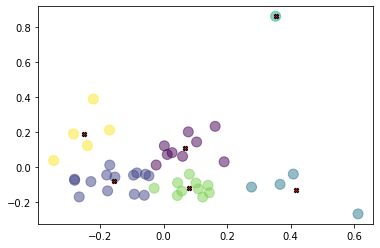

In [ ]:
opt_cluster_no = 6

transformed_data = np.array(transform_data(vectorized_intros, 2))
print(transformed_data.shape)
k_labels, k_centroids = visualise_clusters(transformed_data, opt_cluster_no)

In [ ]:
group['k_clusters'] = k_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def n_most_representative_for_cluster(n, data, cluster_id, groups, centroids):
    group_indices = np.array(groups.get_group(cluster_id).index.tolist())

    """Can omit clusters with less then m docs"""
    if len(group_indices) < 2:
      return []
    most_representative_indices = np.argsort(
      np.linalg.norm(data[group_indices] - centroids[cluster_id], axis=1))[:n]

    return group_indices[most_representative_indices]

In [ ]:
"""Group by clusters"""
intro_groups = group.groupby(['k_clusters'])
print(intro_groups.groups)

"""Get filtered tokens per cluster"""
cluster_to_docs = {} 
n=3
filtered_tokens_clusters = []
for cid in range(opt_cluster_no):
    res = n_most_representative_for_cluster(n, transformed_data, cid, intro_groups, k_centroids)
    if len(res) == 0:
      continue
    cluster_to_docs[cid] = res

    #unsure!!!!
    lemmatised_lists = [filtered_tokens[i] for i in res]
    filtered_tokens_clusters.append(list(itertools.chain(*lemmatised_lists)))

print(cluster_to_docs)

{0: [3, 6, 9, 13, 17, 18, 23, 25, 42], 1: [0, 1, 2, 5, 8, 10, 11, 14, 15, 26, 31, 34, 40, 41], 2: [12, 22, 33, 35], 3: [19], 4: [7, 20, 21, 24, 29, 30, 32, 36, 37, 39], 5: [4, 16, 27, 28, 38]}
{0: array([ 3, 13,  6]), 1: array([15, 10, 41]), 2: array([22, 33, 35]), 4: array([21, 30, 20]), 5: array([16, 38,  4])}


## LDA

In [ ]:
"""Ngrams """

# values change them when more data.
bigram = gensim.models.Phrases(filtered_tokens_clusters, min_count=3, threshold=4) 
trigram = gensim.models.Phrases(bigram[filtered_tokens_clusters], threshold=4)  

bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

def make_bigrams(titles):
    return [bigram_model[title] for title in titles]

def make_trigrams(titles):
    return [trigram_model[bigram_model[title]] for title in titles]

# Form Bigrams
data_words_bigrams = make_bigrams(filtered_tokens_clusters)
print(*list(data_words_bigrams), sep='\n')


# Form Trigrams
# data_words_trigrams = make_trigrams(filtered_tokens_clusters)

['want', 'lowdown', 'market', 'inbox', 'day', 'sign', 'receive', 'euro', 'rescue', 'plan', 'rage', 'track', 'return', 'sky', 'day', 'schedule', 'capacity', 'stick', 'level', 'say', 'analyst', 'specialist', 'market', 'grow', 'fall', 'analyst', 'specialist', 'say', 'lockdown', 'mean', 'hope', 'summer', 'season', 'hang', 'balance', 'analyst', 'say', 'reality', 'airline', 'capacity', 'hit', 'average', 'seat', 'end', 'year', 'passenger', 'demand', 'lag', 'percentage', 'point', 'capacity', 'level', 'period', 'time', 'airline', 'industry', 'lobbyist', 'express', 'optimism', 'travel', 'bounce', 'half', 'start', 'reservation', 'summer', 'stick', 'level', 'half', 'accelerate', 'vaccine', 'campaign', 'health', 'care', 'picture', 'demand', 'pick', 'director', 'general', 'say', 'director', 'general', 'address', 'role', 'give', 'remain', 'half', 'see', 'say', 'director', 'general']
['airline', 'say', 'airline', 'remain', 'travel', 'market', 'revive', 'summer', 'vaccination', 'campaign', 'stutter', '

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Dictionary
lda_dictionary = corpora.Dictionary(data_words_bigrams) #just using bigrams for now

# Term Document Frequency
lda_corpus = [lda_dictionary.doc2bow(text) for text in data_words_bigrams]

# # Create the TF-IDF model
lda_tfidf = TfidfModel(lda_corpus)
corpus_tfidf = lda_tfidf[lda_corpus]

In [ ]:
# can use multicore
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=lda_dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5,
                                           minimum_probability = 0.2,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# min prob tuning

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=lda_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6092483479704679


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, lda_corpus, lda_dictionary, mds='mmds')
pyLDAvis.display(vis)  

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
doc_topics_dist = lda_model[lda_corpus]
cluster_topic_mapping = zip(cluster_to_docs.keys(), doc_topics_dist)

# can add this to dataframe after removing rows with omitted clusters (which have less than min no of elements)
topic_cluster_mapping = {}
for cid, doc in cluster_topic_mapping:
    """ Just picking one dominant topic"""
    t = sorted(doc[0], key=lambda x: (x[1]), reverse=True)[0][0]
    topic_cluster_mapping.setdefault(t, []).append(cid)

keywords = []
topics_to_intros = {}

for t, cs in topic_cluster_mapping.items():
    topic_keywords = ", ".join([w for w, p in lda_model.show_topic(t)])
    keywords.append(topic_keywords)
    docs = [cluster_to_docs.get(cid) for cid in cs]
    docs = list(itertools.chain(*docs))
    topics_to_intros[t] = [coref_intros_filt[d] for d in docs]

topics_df = pd.DataFrame(list(topic_cluster_mapping.items()), columns = ['TopicId','Clusters'])
topics_df['Keywords'] = keywords
pprint(topics_df)

   TopicId   Clusters                                           Keywords
0        0  [0, 2, 4]  day, director, half, analyst, general, adviser...
1        5        [1]  allow, airport, cruise, business, restrict, of...
2        4        [5]  cost, recovery, carrier, base, bud, share, sha...


## NER + Relation Extraction

In [ ]:
ner_predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/fine-grained-ner.2021-02-11.tar.gz")

In [ ]:
def remove_stopwords(text):
  str_stopwords = re.compile(r'\b(' + r'|'.join(stopwords_sp) + r')\b\s*')
  c = re.sub(str_stopwords, ' ', text)
  c = re.sub(r"\s+", " ", c)
  return c

In [ ]:
def get_entities(result):
    entities = set()
    ignore_types = ['DATE', 'TIME', 'CARDINAL', 'PERCENT', 'QUANTITY']
    for word, tag in zip(result["words"], result["tags"]):
        if tag == "O":
          continue
        ent_position, ent_type = tag.split("-")
        if ent_type in ignore_types:
          continue
        if ent_position == "U":
            entities.add((word,ent_type))
        else:
          if ent_position == "B":
              e = word
          elif ent_position == "I":
              e += " " + word
          elif ent_position == "L":
              e += " " + word
              entities.add((e,ent_type))
    return entities

In [ ]:
def get_cooccurence(sents):
  c_sents = []
  for i, s in enumerate(sents):
    if len(s) < 3:
      continue
    # s = coref_predictor.coref_resolved(s.text.strip())
    en = get_entities(ner_predictor.predict(sentence=s.text.strip()))
    if len(en) > 1:
      c_sents.append(en)
  return c_sents

In [ ]:
def intro_cooccurence(intro_sents):
  all_ents = []
  for i, intro in enumerate(intro_sents):
    print("Intro", i)
    occ = get_cooccurence(intro)
    if len(occ) == 0:
      continue
    all_ents.append(occ)
  return all_ents

In [ ]:
def get_relations(all_ents):
  rels = []
  for i in all_ents:
    for ss in i:
      if len(ss) != 2:
        continue
      rels.append(list(zip(*ss))[0])
  return rels

In [ ]:
def get_cooccurence_graph(rels):
  coocc_G = nx.Graph()
  coocc_G.add_edges_from(rels)
  node_deg = nx.degree(coocc_G)
  layout = nx.spring_layout(coocc_G, k=0.5, iterations=60)
  plt.figure(figsize=(25,20))
  nx.draw_networkx(
      coocc_G,
      edge_color='red',
      edgecolors='black',
      node_color='white',
      node_size=[int(deg[1]) * 500 for deg in node_deg],
      pos=layout)
  plt.show()

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 0


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 1


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 2


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 3


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 4


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 5


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 6


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 7


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 8


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

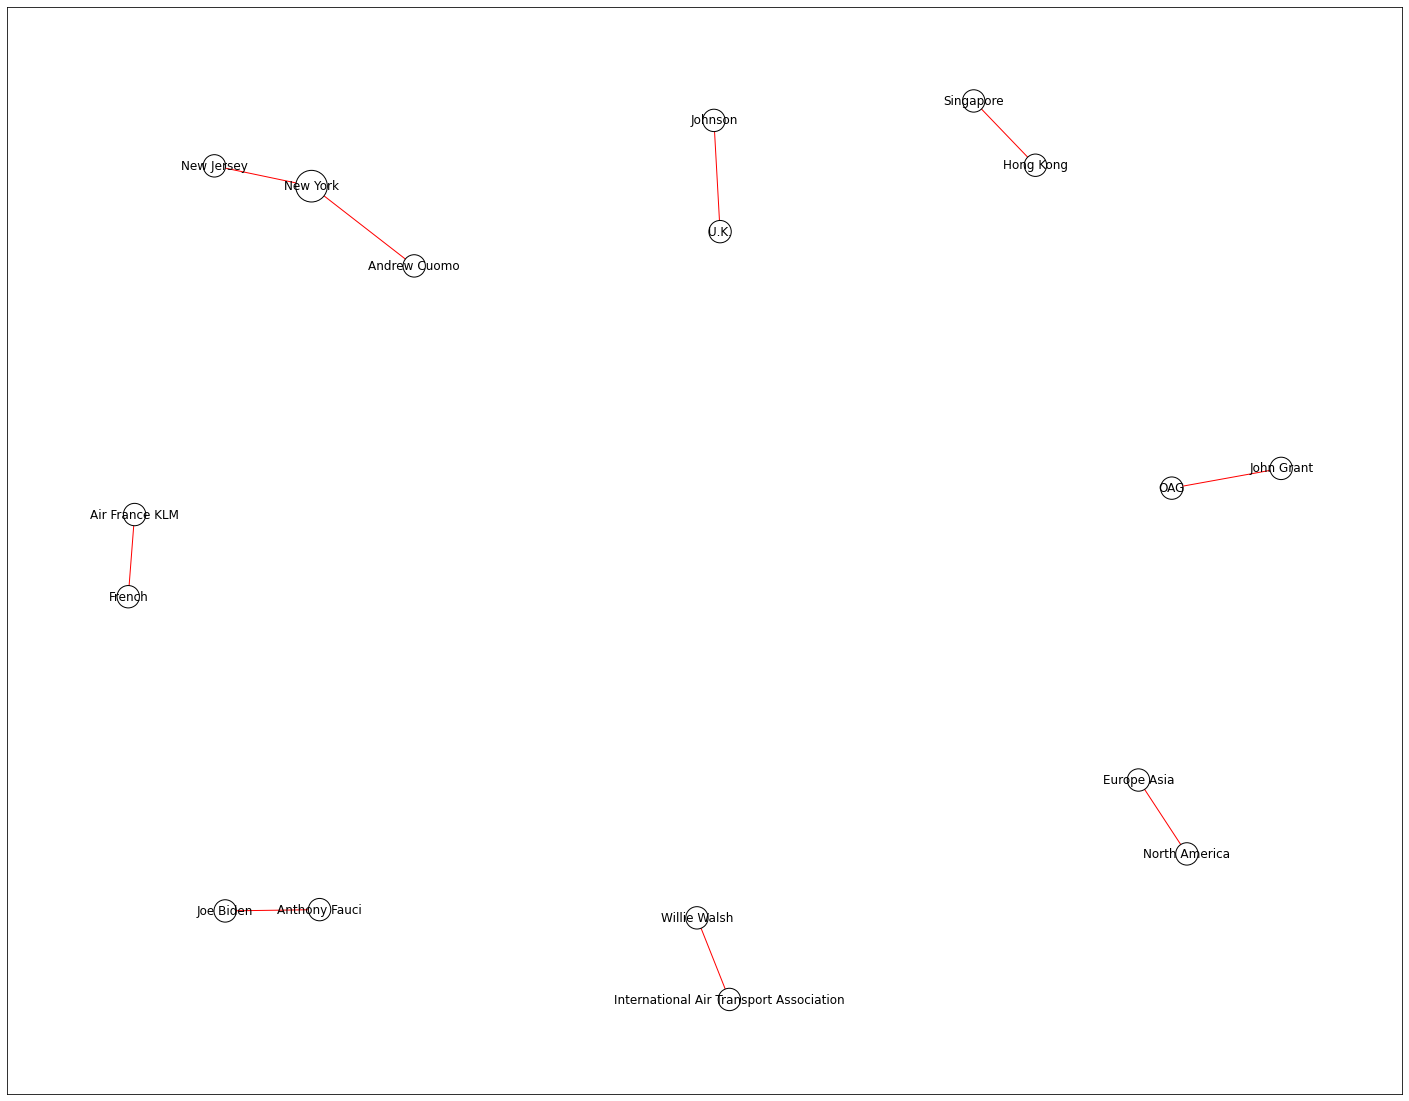

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 0


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 1


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 2


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

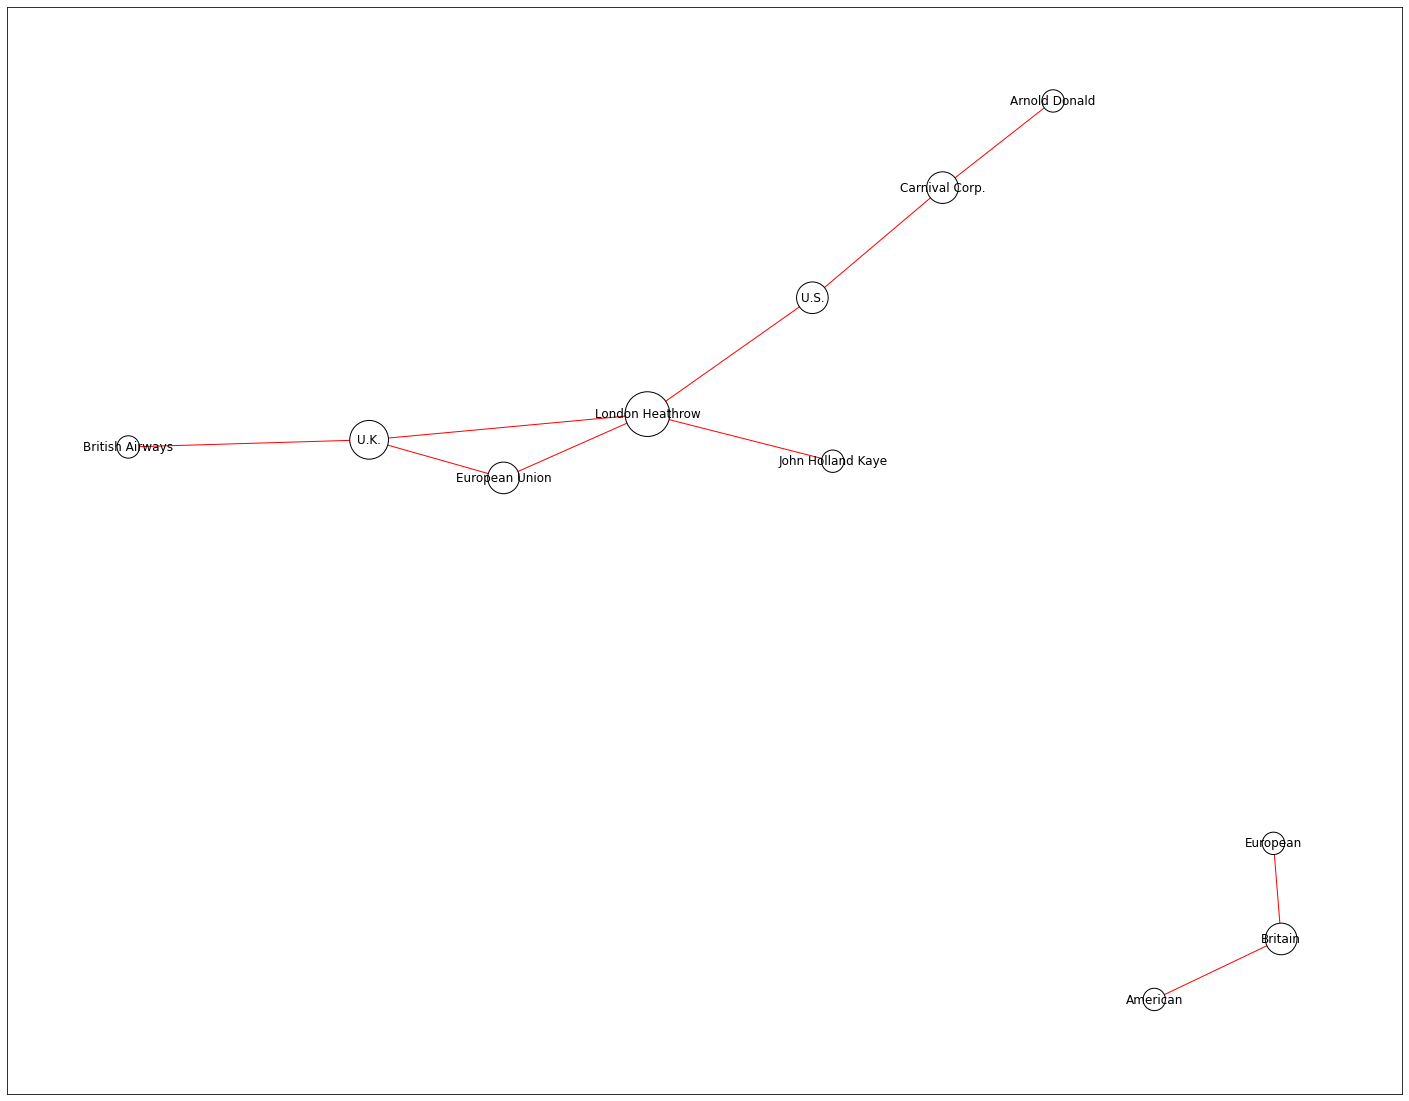

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 0


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 1


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

Intro 2


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

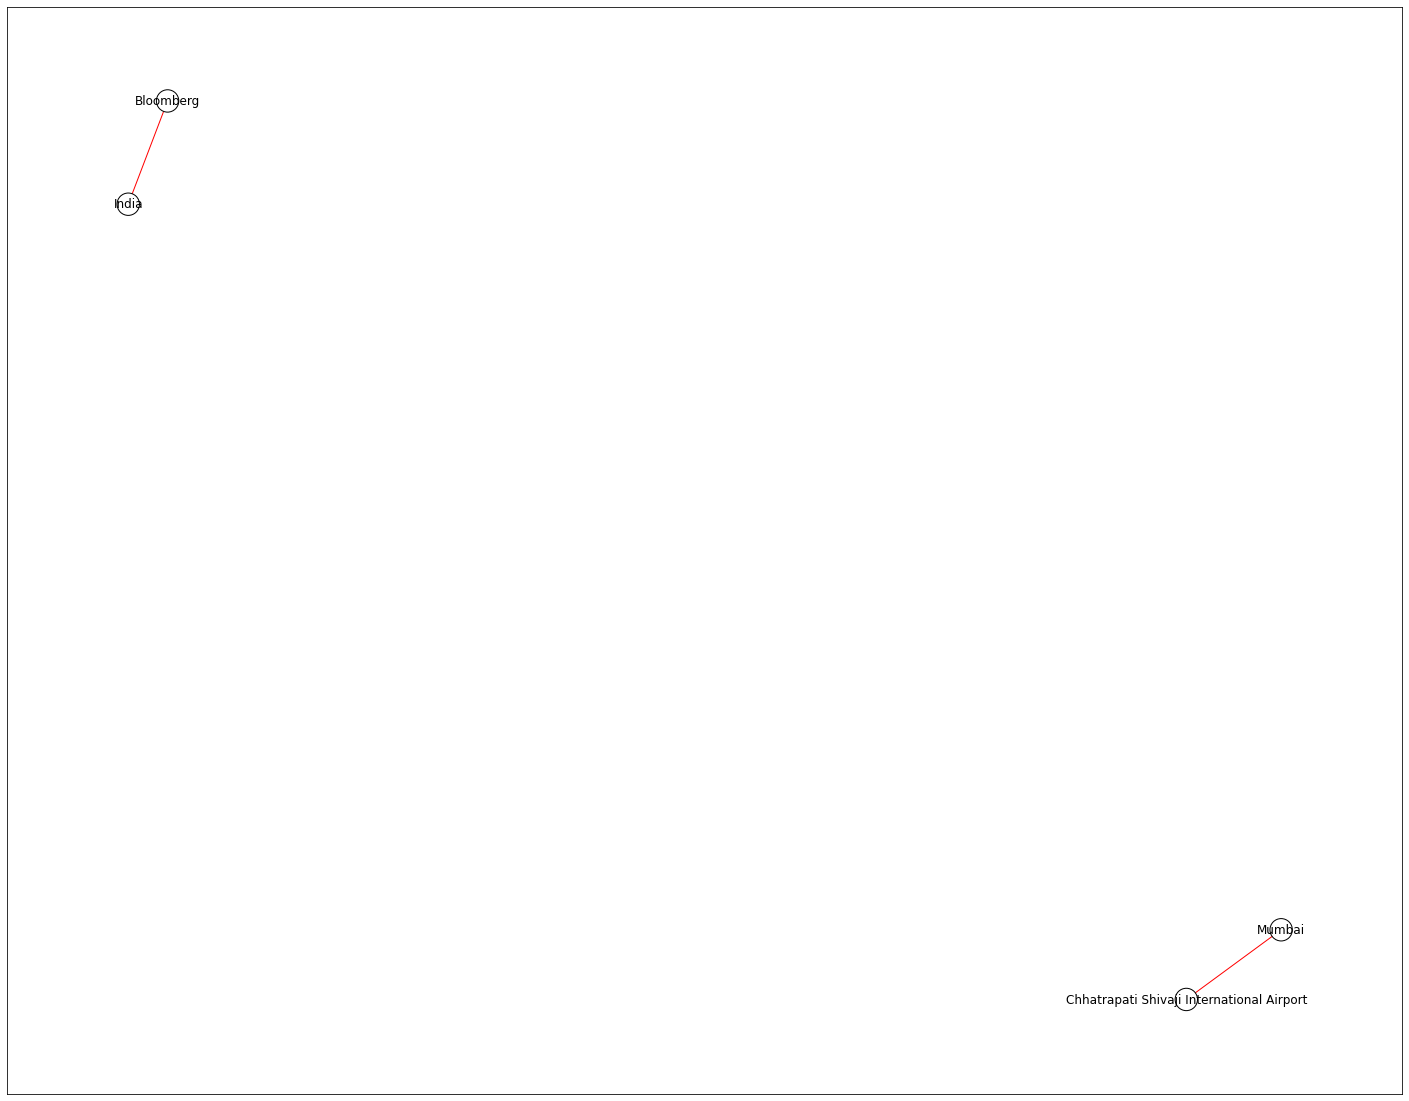

In [ ]:
for t, i in topics_to_intros.items():
  intro_sents = [list(sp(remove_stopwords(a)).sents) for a in i]
  all_ents = intro_cooccurence(intro_sents)
  rels = get_relations(all_ents)
  get_cooccurence_graph(rels)